In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import torch.nn as nn
from time import time

import seaborn as sns
palette = sns.color_palette()
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import ImageGrid

import sys
sys.path.append('../')
from core import distributions, oMCMC

In [3]:
def sample(kernel, init_x, init_v, batch_size, n_iterations, device):
    x = init_x
    v = init_v
    d = torch.zeros(batch_size).long().to(device)
    all_samples = [init_x.cpu().numpy()[:,:,np.newaxis]]
    all_weights = [np.ones([batch_size, 1])]
    AR = 0.0
    for t in range(n_iterations):
        samples, weights, next_state, accepted_mask = kernel(x, v, d)
        x, v, d = next_state
        all_samples.append(samples.cpu().numpy())
        all_weights.append(weights.cpu().numpy())
        AR += np.sum(accepted_mask.cpu().numpy())/batch_size/n_iterations

    all_samples = np.concatenate(all_samples, axis=2)
    all_weights = np.concatenate(all_weights, axis=1)
    return all_samples, all_weights[:,np.newaxis,:], AR


def evaluate_kernel(kernel, init_generator, init_x, batch_size, iterations_grid, true_mean, true_std, device):
    dim = true_mean.shape[0]
    _, init_v = init_generator(batch_size)
    init_x = init_x.to(device)
    samples, weights, AR = sample(kernel, init_x, init_v, batch_size, np.max(iterations_grid), device)
    # number of samples per iteration
    samples = samples[:,:,1:]
    weights = weights[:,:,1:]
    k = (samples.shape[2])//np.max(iterations_grid)
    T = len(iterations_grid)
    errors = np.zeros([batch_size, T])
    errors_std = np.zeros([batch_size, T])
    for t in range(T):
        cur_samples = samples[:,:,:iterations_grid[t]*k]
        cur_weights = weights[:,:,:iterations_grid[t]*k]
        cur_weights = cur_weights/np.sum(weights[:,:,:iterations_grid[t]*k], axis=2, keepdims=True)
        estimate_mean = np.sum(cur_samples*cur_weights, axis=2)
        errors[:,t] = np.sqrt(np.sum((estimate_mean-true_mean)**2, axis=1))
        
        estimate_var = np.sum(cur_weights*(cur_samples-estimate_mean[:,:,np.newaxis])**2, axis=2)
        errors_std[:,t] = np.sqrt(np.sum((estimate_var-true_std**2)**2, axis=1))
    return errors, errors_std, AR

def plot_errors(errors, n_iterations, label):
    errors_sorted = np.sort(errors, axis=0)
    plt.plot(n_iterations, np.mean(errors, axis=0), lw=5, label=label)
    n_chains = errors.shape[0]
    plt.fill_between(n_iterations, errors_sorted[int(n_chains*0.25),:], 
                     errors_sorted[int(n_chains*0.75),:], alpha=0.3)
    plt.xscale('log')
    plt.yscale('log')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('number of iterations', fontsize=25)
    plt.ylabel('absolute error', fontsize=25)

## MogTwo

In [4]:
#preparing target
device = torch.device('cpu')
target = distributions.MOGTwo(device)

#preparing kernels
dim = target.mean().shape[0]
step_size = 1.1
n_steps = 10
batch_size = 100
kernel, init_generator = oMCMC.HMC(target, dim, step_size, n_steps, device)
okernel, init_generator = oMCMC.oHMC(target, dim, step_size, n_steps, device)
rkernel, init_generator = oMCMC.recycled_HMC(target, dim, step_size, n_steps, device)

### Check

Tune the step size to get the acceptance rate of HMC about 0.6

In [5]:
_, init_v = init_generator(batch_size)
init_x = 0.2*torch.zeros([batch_size, dim]).normal_().to(device)
samples, weights, acceptance_rate = sample(kernel, init_x, init_v, batch_size, 1000, device)
print(acceptance_rate)

0.5916499999999993


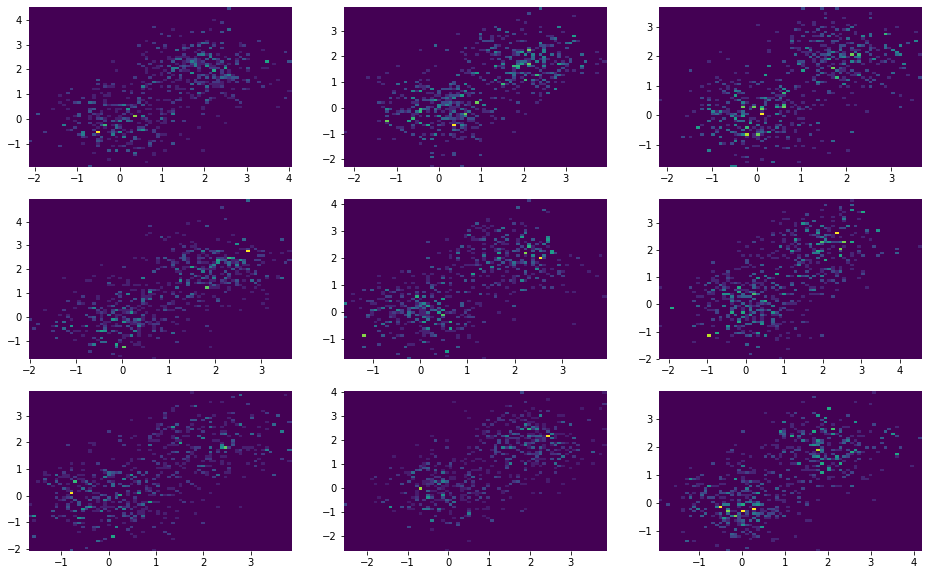

In [6]:
figsize(16,10)
for i in range(9):
    plt.subplot(3,3,i+1)
    _ = plt.hist2d(samples[i,0,:], samples[i,1,:], bins=70)
    plt.box(False)

### Compare

In [7]:
n_iterations = np.unique(np.logspace(0,3,30, dtype=int))
errors, errors_std, AR = evaluate_kernel(kernel, init_generator, init_x, batch_size, 
                                         n_iterations, target.mean(), target.std(), device)
errors_r, errors_std_r, AR_r = evaluate_kernel(rkernel, init_generator, init_x, batch_size, 
                                               n_iterations, target.mean(), target.std(), device)
errors_o, errors_std_o, AR_o = evaluate_kernel(okernel, init_generator, init_x, batch_size, 
                                               n_iterations, target.mean(), target.std(), device)
errors_o, errors_std_o, AR_o = evaluate_kernel(okernel, init_generator, init_x, batch_size, 
                                               n_iterations, target.mean(), target.std(), device)

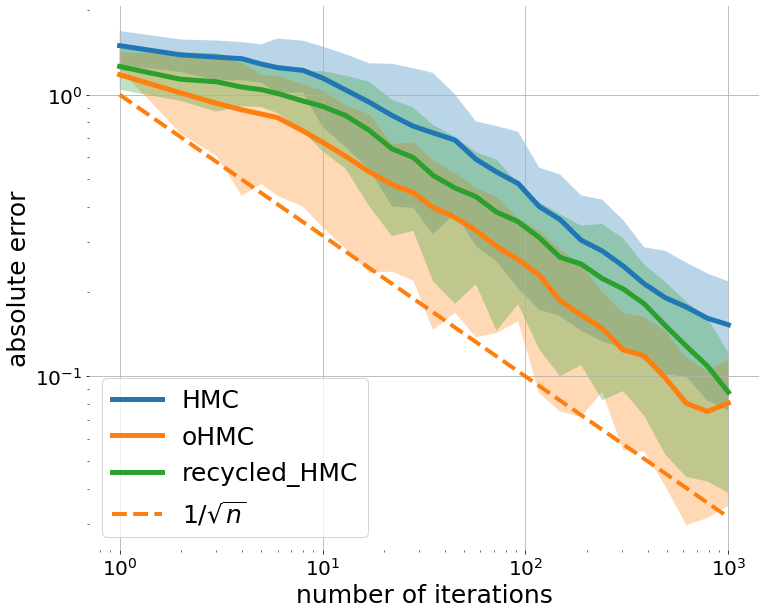

In [8]:
figsize(12,10)
# plt.title('mean estimation', fontsize=25)
plot_errors(errors, n_iterations, 'HMC')
plot_errors(errors_o, n_iterations, 'oHMC')
plot_errors(errors_r, n_iterations, 'recycled_HMC')
plt.plot(n_iterations, 1.0/np.sqrt(n_iterations), color=palette[1], ls='--', lw=4, label=r'$1/\sqrt{n}$')
plt.box(False)
plt.legend(fontsize=25)
plt.grid()
# plt.savefig('oHMC_body.pdf', bbox_inches='tight')

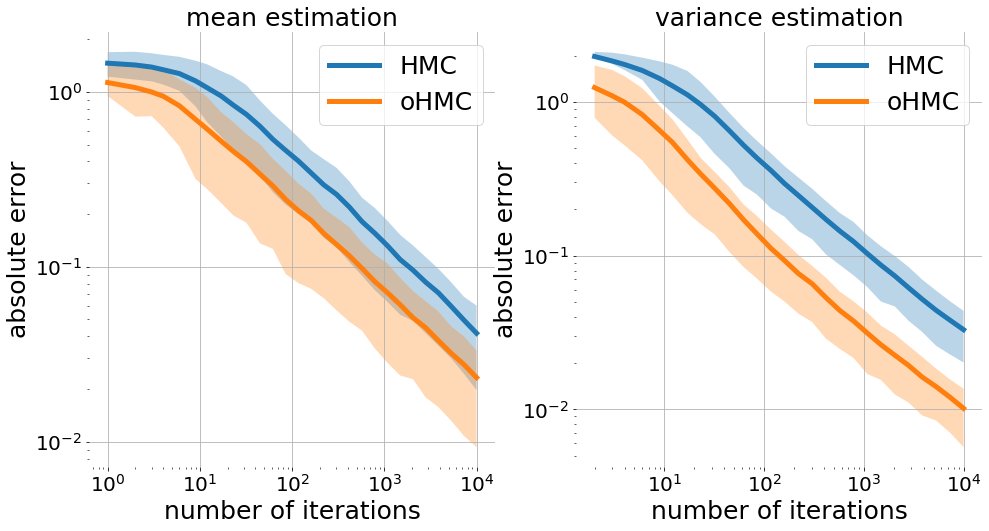

In [10]:
figsize(16,8)
plt.subplot(1,2,1)
plt.title('mean estimation', fontsize=25)
plot_errors(errors, n_iterations, 'HMC')
plot_errors(errors_o, n_iterations, 'oHMC')
plt.box(False)
plt.legend(fontsize=25)
plt.grid()
plt.subplot(1,2,2)
plt.title('variance estimation', fontsize=25)
plot_errors(errors_std[:,1:], n_iterations[1:], 'HMC')
plot_errors(errors_std_o[:,1:], n_iterations[1:], 'oHMC')
plt.box(False)
plt.legend(fontsize=25)
plt.grid()
# plt.savefig('oHMC_MOGTwo.pdf', bbox_inches='tight')

## Ring

In [21]:
#preparing target
device = torch.device('cuda')
target = distributions.Ring(device)

#preparing kernels
dim = target.mean().shape[0]
step_size = 0.72
n_steps = 10
batch_size = 1000
kernel, init_generator = oMCMC.HMC(target, dim, step_size, n_steps, device)
okernel, init_generator = oMCMC.oHMC(target, dim, step_size, n_steps, device)

### Check

In [22]:
_, init_v = init_generator(batch_size)
init_x = (0.2*torch.zeros([batch_size, dim]).normal_()+torch.Tensor([0.0,2.0])).to(device)
samples, weights, acceptance_rate = sample(kernel, init_x, init_v, batch_size, 1000, device)
print(acceptance_rate)

0.6063359999999999


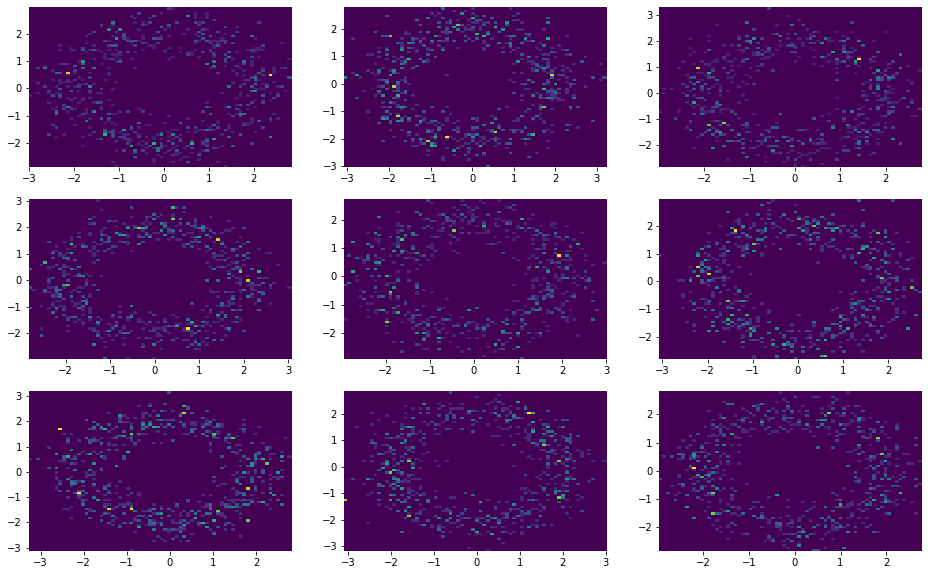

In [23]:
figsize(16,10)
for i in range(9):
    plt.subplot(3,3,i+1)
    _ = plt.hist2d(samples[i,0,:], samples[i,1,:], bins=70)
    plt.box(False)

### Compare

In [24]:
n_iterations = np.unique(np.logspace(0,4,30, dtype=int))
errors, errors_std, AR = evaluate_kernel(kernel, init_generator, init_x, batch_size, 
                                         n_iterations, target.mean(), target.std(), device)
errors_o, errors_std_o, AR_o = evaluate_kernel(okernel, init_generator, init_x, batch_size, 
                                               n_iterations, target.mean(), target.std(), device)

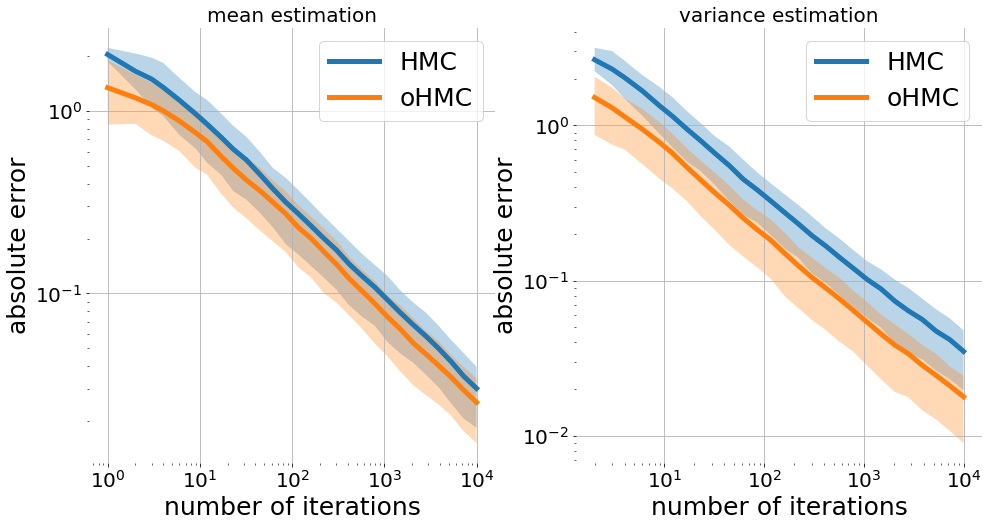

In [26]:
figsize(16,8)
plt.subplot(1,2,1)
plt.title('mean estimation', fontsize=20)
plot_errors(errors, n_iterations, 'HMC')
plot_errors(errors_o, n_iterations, 'oHMC')
plt.box(False)
plt.legend(fontsize=25)
plt.grid()
plt.subplot(1,2,2)
plt.title('variance estimation', fontsize=20)
plot_errors(errors_std[:,1:], n_iterations[1:], 'HMC')
plot_errors(errors_std_o[:,1:], n_iterations[1:], 'oHMC')
plt.box(False)
plt.legend(fontsize=25)
plt.grid()
plt.savefig('oHMC_Ring.pdf', bbox_inches='tight')

## Heart

In [15]:
#preparing target
device = torch.device('cpu')
target = distributions.Heart(device)

#preparing kernels
dim = target.mean().shape[0]
step_size = 0.15
n_steps = 10
batch_size = 100
kernel, init_generator = oMCMC.HMC(target, dim, step_size, n_steps, device)
okernel, init_generator = oMCMC.oHMC(target, dim, step_size, n_steps, device)
rkernel, init_generator = oMCMC.recycled_HMC(target, dim, step_size, n_steps, device)

### Check

In [16]:
_, init_v = init_generator(batch_size)
init_x = (0.5*torch.zeros([batch_size, dim]).normal_() + target.mean()).to(device)
samples, weights, acceptance_rate = sample(kernel, init_x, init_v, batch_size, 100, device)
print(acceptance_rate)

0.7053000000000001


### Compare

In [17]:
%%time
n_iterations = np.unique(np.logspace(0,4,10, dtype=int))
errors_o, errors_std_o, AR_o = evaluate_kernel(okernel, init_generator, init_x, batch_size, 
                                               n_iterations, target.mean(), target.std(), device)
errors, errors_std, AR = evaluate_kernel(kernel, init_generator, init_x, batch_size, 
                                         n_iterations, target.mean(), target.std(), device)
errors_r, errors_std_r, AR_r = evaluate_kernel(rkernel, init_generator, init_x, batch_size, 
                                               n_iterations, target.mean(), target.std(), device)

CPU times: user 15min 46s, sys: 36.9 s, total: 16min 23s
Wall time: 16min 24s


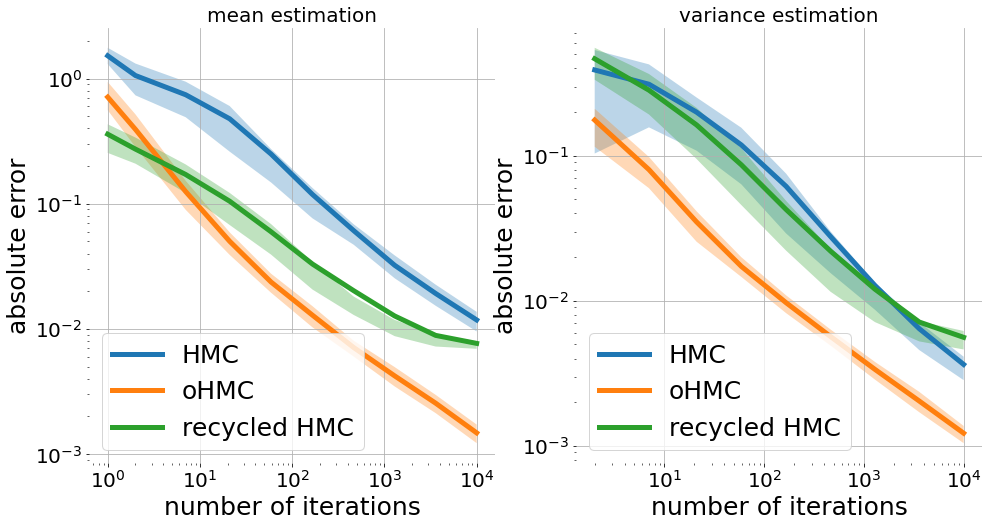

In [19]:
figsize(16,8)
plt.subplot(1,2,1)
plt.title('mean estimation', fontsize=20)
plot_errors(errors, n_iterations, 'HMC')
plot_errors(errors_o, n_iterations, 'oHMC')
plot_errors(errors_r, n_iterations, 'recycled HMC')
plt.box(False)
plt.legend(fontsize=25)
plt.grid()
plt.subplot(1,2,2)
plt.title('variance estimation', fontsize=20)
plot_errors(errors_std[:,1:], n_iterations[1:], 'HMC')
plot_errors(errors_std_o[:,1:], n_iterations[1:], 'oHMC')
plot_errors(errors_std_r[:,1:], n_iterations[1:], 'recycled HMC')
plt.box(False)
plt.legend(fontsize=25)
plt.grid()
plt.savefig('oHMC_Heart_with_recycling.pdf', bbox_inches='tight')

## Australian

In [31]:
#preparing target
device = torch.device('cuda')
target = distributions.Australian(device)

#preparing kernels
dim = target.mean().shape[0]
step_size = 0.12
n_steps = 10
batch_size = 1000
kernel, init_generator = oMCMC.HMC(target, dim, step_size, n_steps, device)
okernel, init_generator = oMCMC.oHMC(target, dim, step_size, n_steps, device)

### Check

In [32]:
_, init_v = init_generator(batch_size)
init_x = (0.5*torch.zeros([batch_size, dim]).normal_() + target.mean()).to(device)
samples, weights, acceptance_rate = sample(kernel, init_x, init_v, batch_size, 1000, device)
print(acceptance_rate)

0.6011749999999992


### Compare

In [33]:
n_iterations = np.unique(np.logspace(0,4,30, dtype=int))
errors, errors_std, AR = evaluate_kernel(kernel, init_generator, init_x, batch_size, 
                                         n_iterations, target.mean(), target.std(), device)
errors_o, errors_std_o, AR_o = evaluate_kernel(okernel, init_generator, init_x, batch_size, 
                                               n_iterations, target.mean(), target.std(), device)

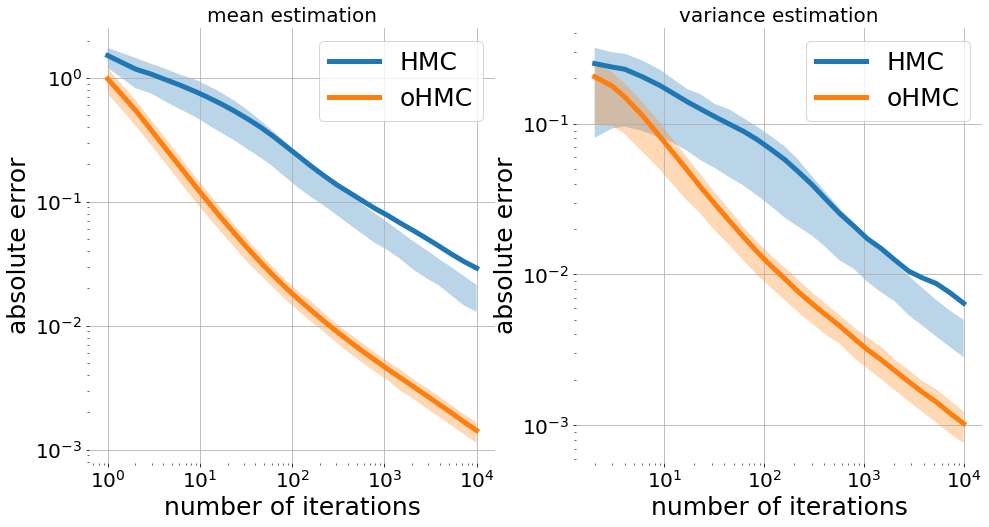

In [34]:
figsize(16,8)
plt.subplot(1,2,1)
plt.title('mean estimation', fontsize=20)
plot_errors(errors, n_iterations, 'HMC')
plot_errors(errors_o, n_iterations, 'oHMC')
plt.box(False)
plt.legend(fontsize=25)
plt.grid()
plt.subplot(1,2,2)
plt.title('variance estimation', fontsize=20)
plot_errors(errors_std[:,1:], n_iterations[1:], 'HMC')
plot_errors(errors_std_o[:,1:], n_iterations[1:], 'oHMC')
plt.box(False)
plt.legend(fontsize=25)
plt.grid()
plt.savefig('oHMC_Australian.pdf', bbox_inches='tight')

## German

In [35]:
#preparing target
device = torch.device('cuda')
target = distributions.German(device)

#preparing kernels
dim = target.mean().shape[0]
step_size = 0.07
n_steps = 10
batch_size = 1000
kernel, init_generator = oMCMC.HMC(target, dim, step_size, n_steps, device)
okernel, init_generator = oMCMC.oHMC(target, dim, step_size, n_steps, device)

### Check

In [36]:
_, init_v = init_generator(batch_size)
init_x = (0.5*torch.zeros([batch_size, dim]).normal_() + target.mean()).to(device)
samples, weights, acceptance_rate = sample(kernel, init_x, init_v, batch_size, 1000, device)
print(acceptance_rate)

0.677117000000001


### Compare

In [37]:
n_iterations = np.unique(np.logspace(0,4,30, dtype=int))
errors, errors_std, AR = evaluate_kernel(kernel, init_generator, init_x, batch_size, 
                                         n_iterations, target.mean(), target.std(), device)
errors_o, errors_std_o, AR_o = evaluate_kernel(okernel, init_generator, init_x, batch_size, 
                                               n_iterations, target.mean(), target.std(), device)

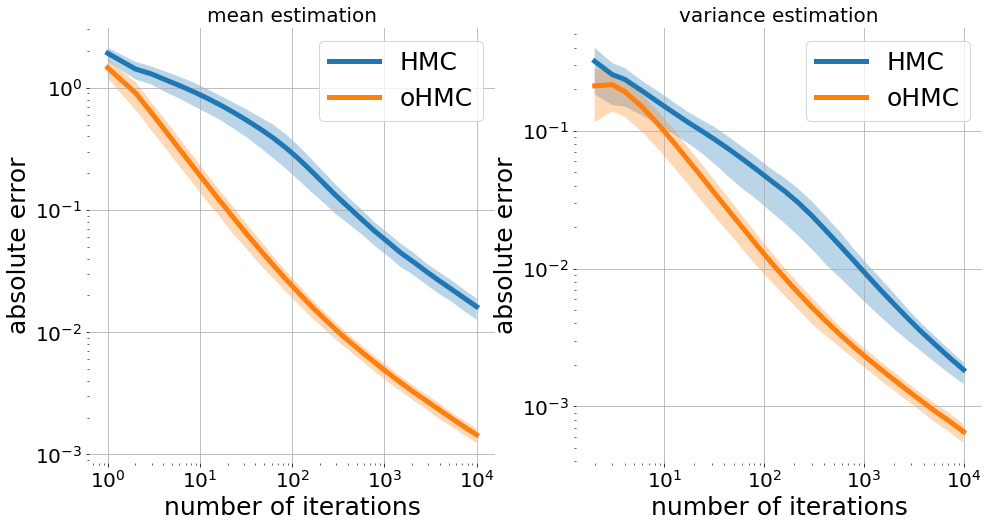

In [38]:
figsize(16,8)
plt.subplot(1,2,1)
plt.title('mean estimation', fontsize=20)
plot_errors(errors, n_iterations, 'HMC')
plot_errors(errors_o, n_iterations, 'oHMC')
plt.box(False)
plt.legend(fontsize=25)
plt.grid()
plt.subplot(1,2,2)
plt.title('variance estimation', fontsize=20)
plot_errors(errors_std[:,1:], n_iterations[1:], 'HMC')
plot_errors(errors_std_o[:,1:], n_iterations[1:], 'oHMC')
plt.box(False)
plt.legend(fontsize=25)
plt.grid()
plt.savefig('oHMC_German.pdf', bbox_inches='tight')

In [ ]:
_, init_v = init_generator(batch_size)
init_x = (0.5*torch.zeros([batch_size, dim]).normal_() + target.mean()).to(device)
samples, weights, acceptance_rate = sample(kernel, init_x, init_v, batch_size, 100000, device)

burn_in = 10000
norm = np.sum(weights[:,:,burn_in:], axis=2, keepdims=True)
estimate_mean = np.sum(samples[:,:,burn_in:]*weights[:,:,burn_in:]/norm, axis=2)
estimate_mean = np.mean(estimate_mean, axis=0)
estimate_var = np.sum(weights[:,:,burn_in:]/norm*(samples[:,:,burn_in:]-estimate_mean[np.newaxis,:,np.newaxis])**2, axis=2)
estimate_std = np.sqrt(np.mean(estimate_var, axis=0))